In [ ]:
import zipfile
with zipfile.ZipFile(directory+'ecg_ppg_25_left.zip', 'r') as zip_ref:
    zip_ref.extractall(directory+'ecg_ppg_25_left')

In [ ]:
directory = '../../cc3/rice_data/ecg_ppg_25_left/'

In [145]:
from scipy.stats import iqr
from datetime import datetime
from copy import deepcopy
import math
from scipy.stats import pearsonr
from sklearn.externals.joblib import Parallel,delayed
import warnings
import pandas as pd
import pickle
import os
import numpy as np
warnings.filterwarnings('ignore')

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return average, math.sqrt(variance)

def get_rr_features(a):
    return np.array([np.var(a),iqr(a),np.mean(a),np.median(a),np.percentile(a,80),np.percentile(a,20),60000/np.median(a)])

def get_quality_features(a):
    features = [np.median(a),
                len(np.where(a>0)[0])/60,len(np.where(a>.2)[0])/60,
                len(np.where(a>.4)[0])/60,len(np.where(a>.6)[0])/60,
                len(np.where(a>.8)[0])/60,len(np.where(a==0)[0])/60]
    return np.array(features)

def get_daywise(data):
    return [a for i,a in data.groupby(['user','day']) if a.dropna().shape[0]>60]

def parse_day_data(data_day):
    data_day = data_day.sort_values('ltime').reset_index(drop=True)
    data_day['likelihood_max_array'] = data_day['likelihood_max_array'].apply(lambda a:np.squeeze(a).reshape(-1,3))
    data_day['likelihood'] = data_day['likelihood_max_array'].apply(lambda a:np.max(a,axis=1))
    data_day['likelihood_ind'] = data_day['likelihood_max_array'].apply(lambda a:np.argmax(a,axis=1))
    data_day['rr_array'] = data_day['rr_array'].apply(lambda a:np.squeeze(a).reshape(-1,3))
    data_day['length'] = data_day['rr_array'].apply(lambda a:a.shape[0])
    data_day = data_day[data_day.length>30]
    data_day['time'] = data_day['ltime'].apply(lambda a:datetime.timestamp(a))
    indexes = data_day['likelihood_ind'].values
    rr_arrays = data_day['rr_array'].values
    rrs = []
    for i,rr in enumerate(rr_arrays):
        index = indexes[i]
        frr = np.squeeze(np.array([rr[i,index[i]] for i in range(rr.shape[0])]))
        rrs.append(frr)
    data_day['rr'] = rrs
    data_day['rr_col'] = data_day.apply(lambda a: np.vstack([np.squeeze(a['rr']),np.squeeze(a['likelihood'])]).T,
                     axis=1)
    return data_day

def remove_3sd(heart_rate_window):
    temp = deepcopy(heart_rate_window)
    try:
        r,tt = weighted_avg_and_std(heart_rate_window[heart_rate_window[:,1]>.25,0],heart_rate_window[heart_rate_window[:,1]>.25,1])
        index = np.where((heart_rate_window[:,0]<r+3*tt)&(heart_rate_window[:,0]>r-3*tt))[0]
        heart_rate_window = heart_rate_window[index]
    except:
        pass
    if heart_rate_window.shape[0]>10:
        return [heart_rate_window,'Available']
    else:
        return [temp,'Not Available']

    
def parse_for_features(data_day):
    data_day['rr_col'] = data_day['rr_col'].apply(lambda a:a[np.where((a[:,1]>.05)&(a[:,0]>300)&(a[:,0]<1500))[0]])
    data_day['rr_col'] = data_day['rr_col'].apply(lambda a:remove_3sd(a))
    data_day['length1'] = data_day['rr_col'].apply(lambda a:a[0].shape[0])
    data_day = data_day[data_day.length1>30]
    data_day['indicator'] = data_day['rr_col'].apply(lambda a:a[1])
    data_day['rr_col'] = data_day['rr_col'].apply(lambda a:a[0])
    data_day['likelihood'] = data_day['rr_col'].apply(lambda a:a[:,1])
    data_day['rr'] = data_day['rr_col'].apply(lambda a:a[:,0])
    data_day['rr_features'] = data_day['rr'].apply(lambda a:get_rr_features(a))
    data_day['quality_features'] = data_day['likelihood'].apply(lambda a:get_quality_features(a))
    data_day['quality_mag'] = data_day['quality_features'].apply(lambda a:np.sqrt(np.sum(np.square(a))/len(a)))
    return data_day

def get_stress(data_day,stress_model):
    feature_matrix = np.array(list(data_day['rr_features'].values))
    quals1 = np.array(list(data_day['quality_mag'].values))
    for i in range(feature_matrix.shape[1]):
        m,s = weighted_avg_and_std(feature_matrix[:,i], quals1)
        feature_matrix[:,i]  = (feature_matrix[:,i] - m)/s
    stress_likelihood = stress_model.predict_proba(feature_matrix)[:,1]
#     print(data_day.shape,stress_likelihood.shape)
    data_day['stress_likelihood1'] = stress_likelihood
    return data_day

def get_corr1(data_day1):
    if data_day1.shape[0]<60:
        return np.zeros((0,6))
    data_day1['quality_mag_1'] = data_day1['quality_mag'].apply(lambda a:np.round(1000*a)//10)
    tmp = data_day1[['quality_mag_1','stress_likelihood']].dropna()
    data_day = data_day1.dropna()
    if data_day.shape[0]<60:
        return np.zeros((0,6))
    all_corr = np.array([np.array([df['quality_mag_1'].values[0],
                          pearsonr(df['stress_likelihood_ecg'].values,df['stress_likelihood'].values)[0],
                          pearsonr(df['stress_likelihood_ecg'].values,df['stress_likelihood1'].values)[0],
                          pearsonr(df['stress_likelihood'].values,df['stress_likelihood1'].values)[0],
                          tmp[tmp.quality_mag_1.isin([df['quality_mag_1'].values[0]])].shape[0],
                          data_day1['stress_likelihood_ecg'].dropna().shape[0]]) for i,df in data_day.groupby(['quality_mag_1']) if df.shape[0]>10])
    return all_corr

def get_corr(data_day1):
    if data_day1.shape[0]<60:
        return np.zeros((0,6))
    data_day1['quality_mag_1'] = data_day1['quality_mag'].apply(lambda a:np.round(100*a)/100)
    all_corr = []
    print(data_day1['quality_mag_1'].values)
    for q in np.unique(data_day1['quality_mag_1'].values):
        tmp = data_day1[data_day1.quality_mag_1>=q]
        tmp2 = tmp[['stress_likelihood_ecg','stress_likelihood','stress_likelihood1']].dropna()
        if tmp2.shape[0]<10:
            continue
        feature = np.array([q,
                   pearsonr(tmp2['stress_likelihood_ecg'].values,tmp2['stress_likelihood'].values)[0],
                   pearsonr(tmp2['stress_likelihood_ecg'].values,tmp2['stress_likelihood1'].values)[0],
                   pearsonr(tmp2['stress_likelihood'].values,tmp2['stress_likelihood1'].values)[0],
                   tmp['stress_likelihood1'].dropna().shape[0],
                   data_day1['stress_likelihood_ecg'].dropna().shape[0]])
        all_corr.append(feature)
    return np.array(all_corr)

def parse_each_day(a):
    a = parse_day_data(a)
    a = parse_for_features(a)
    stress_model = pickle.load(open('../models/stress_model.p','rb'))
    a = get_stress(a,stress_model)
    all_corr = get_corr(a)
    return all_corr

def parse_each_participant(directory,d):
    data = pickle.load(open(directory+d,'rb'))
    data_all = get_daywise(data)
    if len(data_all)==0:
        return np.zeros((0,6))
    final_output = np.concatenate([parse_each_day(a) for a in data_all])
    return final_output

directory = '../../cc3/rice_data/ecg_ppg_25_left/'
data = Parallel(n_jobs=30,verbose=2)(delayed(parse_each_participant)(directory,d) for d in os.listdir(directory) if d[-1]=='p')
# data = [parse_each_participant(directory,d) for d in os.listdir(directory) if d[-1]=='p']

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  89 out of  98 | elapsed:  1.5min remaining:    9.2s
[Parallel(n_jobs=30)]: Done  98 out of  98 | elapsed:  1.9min finished


In [146]:
data_all = pd.DataFrame(np.concatenate(data),columns=['quality','corr_orig','corr_new','corr_between','ppg_yield','ecg_yield'])
data_all['quality'].unique()

array([23., 29., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
       43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
       56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68.,
       69., 70., 21., 25., 26., 27., 28., 30., 31., 71., 72., 73., 74.,
       75., 76., 77., 78., 79., 80., 81., 82., 83., 84., 85., 86., 20.,
       22., 24., 87., 88., 89., 90., 91., 92., 93.])

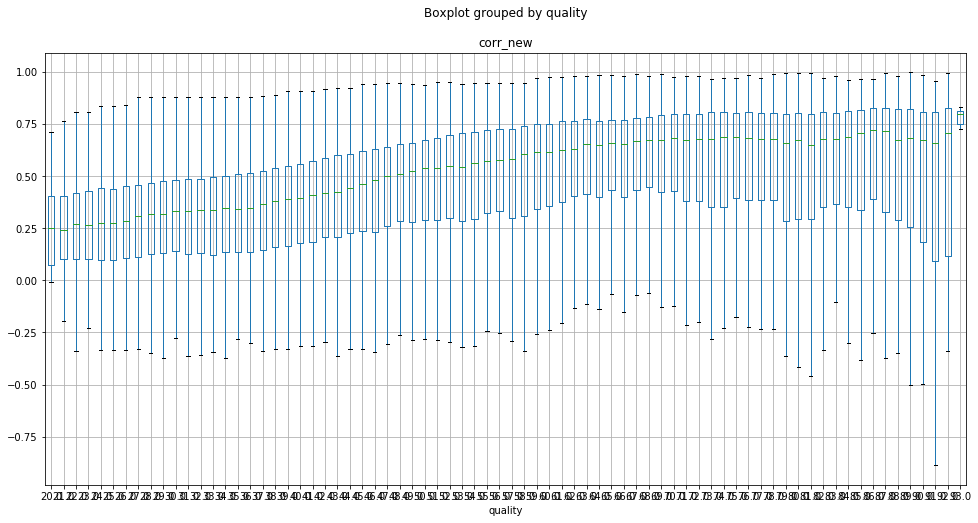

In [147]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('')
c = data_all.boxplot(column=['corr_new'], by='quality', ax=ax,showfliers=False)
# plt.xticks(rotation=100)

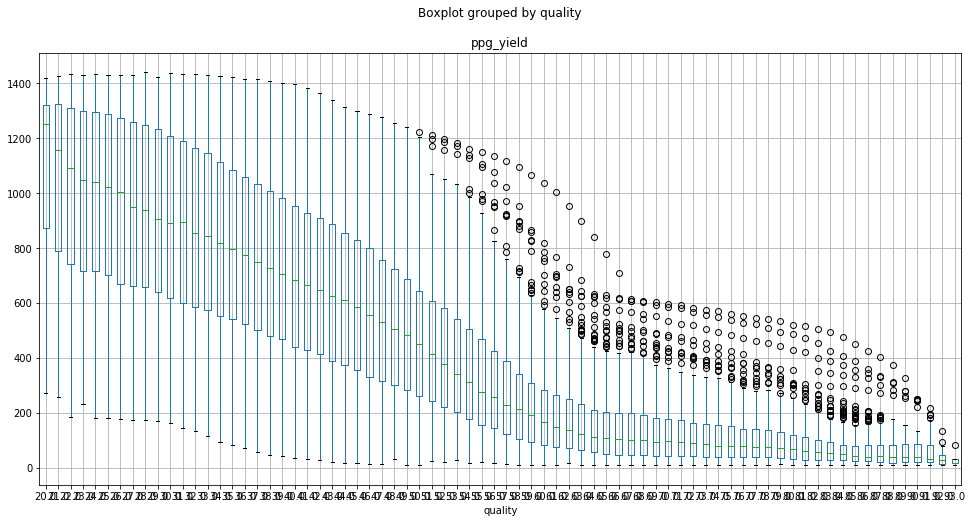

In [148]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('')
c = data_all.boxplot(column=['ppg_yield'], by='quality', ax=ax)

In [128]:
data_all.groupby('quality').mean(),data_all.groupby('quality').quantile(.25)

(         corr_orig  corr_new  corr_between    ppg_yield   ecg_yield
 quality                                                            
 0.0       0.271433  0.332911      0.709484  1101.823529  304.588235
 1.0       0.227318  0.283979      0.675370  1089.982759  272.500000
 2.0       0.204182  0.277993      0.704331  1020.870968  282.268817
 3.0       0.216477  0.291762      0.712466   975.992500  279.832500
 4.0       0.222936  0.299778      0.712373   926.808458  278.990050
 5.0       0.253239  0.333189      0.716843   761.512438  278.990050
 6.0       0.332280  0.422780      0.707472   509.914948  285.340206
 7.0       0.393771  0.495978      0.641908   198.110465  304.270349
 8.0       0.466993  0.547200      0.606577   129.678295  329.124031
 9.0       0.487232  0.533432      0.643057    96.213415  366.536585
 10.0      0.778769  0.831690      0.929249    37.333333  338.000000,
 0.25     corr_orig  corr_new  corr_between  ppg_yield  ecg_yield
 quality                            